In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
from matplotlib.pylab import rcParams
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import (ExponentialSmoothing, 
                                         SimpleExpSmoothing,Holt)
import seaborn as sns

F:\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
F:\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


In [2]:
data = pd.read_excel('E:/postgraduate/案例选题数据及说明/小麦.xlsx')

In [3]:
data['时间'] = data['时间'].str.split(',').str[0]
data.index = data['时间']
data = data[['开盘','最高','最低','收盘','总手']]
data.head()

,开盘,最高,最低,收盘,总手
时间,,,,,
2021-01-04,643.00,650.25,634.0,643.25,64662
2021-01-05,641.50,664.50,639.5,653.25,78021
2021-01-06,654.00,660.25,646.0,647.50,47047
2021-01-07,646.75,648.25,638.0,643.75,45862
2021-01-08,644.75,649.50,634.0,638.00,51082


In [4]:
data1 = data.loc['2021-01-12':'2022-02-23']#取2022-2-24之前的数据
data1.tail()

,开盘,最高,最低,收盘,总手
时间,,,,,
2022-02-16,779.75,786.75,773.25,779.00,30459
2022-02-17,780.00,799.25,775.50,796.75,39362
2022-02-18,797.50,812.25,790.00,793.75,37767
2022-02-22,815.00,846.25,803.00,839.75,44590
2022-02-23,841.00,880.00,834.00,874.50,26272


Text(0, 0.5, '收盘价')

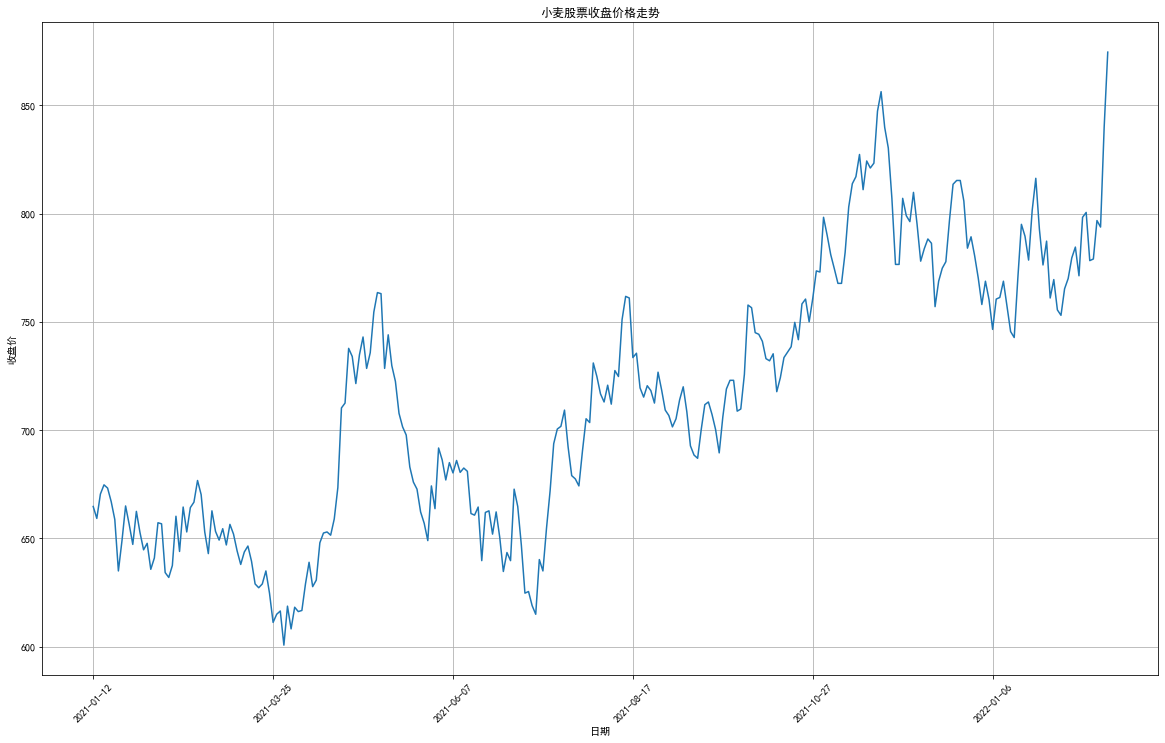

In [5]:
#绘制时序图
ts = data1['收盘']
plt.rcParams['font.sans-serif'] = ['simhei']  #用来正常显示中文标签 
plt.rcParams['axes.unicode_minus'] = False #用来正常显示负号 
ts.plot(figsize=(20,12))         
plt.title("小麦股票收盘价格走势")  #添加图标题 
plt.xticks(rotation=45)  #横坐标旋转45度
plt.grid()
plt.xlabel('日期')   #添加图的标签（x轴，y轴）
plt.ylabel('收盘价')

<ipython-input-6-728eb4f5f9c9>:10: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead.
  decomposition = seasonal_decompose(ts,model='multiplicative', freq=30)


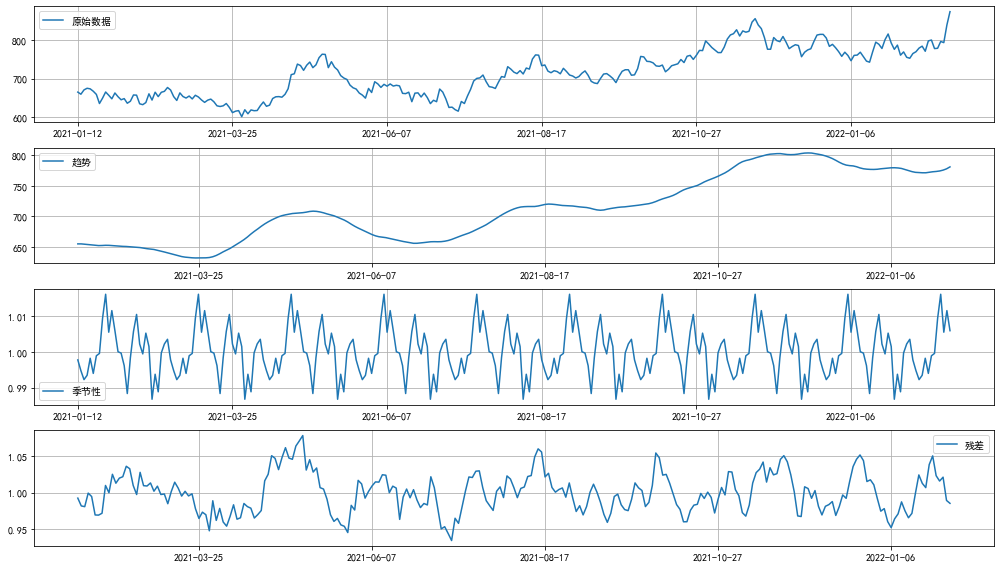

In [6]:
import matplotlib.ticker as ticker
rcParams['figure.figsize'] = 14, 8
#result = seasonal_decompose(ts, model='multiplicative', freq=30)
#plt.figure(figsize=(16,8))
#fig = result.plot()
#plt.grid()
#plt.show()


decomposition = seasonal_decompose(ts,model='multiplicative', freq=30)
trend = decomposition.trend #趋势效应
seasonal = decomposition.seasonal #季节效应
residual = decomposition.resid #随机效应
ax = plt.subplot(411)
ax.grid()
ax.plot(ts, label=u'原始数据')
ax.xaxis.set_major_locator(ticker.MultipleLocator(base=50))
plt.legend(loc='best')
ax = plt.subplot(412)
ax.grid()
ax.plot(trend, label=u'趋势')
ax.xaxis.set_major_locator(ticker.MultipleLocator(base=50))
plt.legend(loc='best')
ax = plt.subplot(413)
ax.grid()
ax.plot(seasonal,label=u'季节性')
ax.xaxis.set_major_locator(ticker.MultipleLocator(base=50))
plt.legend(loc='best')
ax = plt.subplot(414)
ax.grid()
ax.plot(residual, label=u'残差')
ax.xaxis.set_major_locator(ticker.MultipleLocator(base=50))
plt.legend(loc='best')
plt.tight_layout()

In [7]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    rollmean = timeseries.rolling(8).mean()
    rollstd  = timeseries.rolling(8).std()
    
    # plot rolling stats
    ax = plt.subplot(111)
    orig = plt.plot(timeseries, color = 'red', label = '原始序列')
    mean = plt.plot(rollmean, color='green', label = '移动平均')
    std  = plt.plot(rollstd, color = 'blue', label = '移动标准差')
    ax.xaxis.set_major_locator(ticker.MultipleLocator(base=50))
    plt.legend(loc = 'best')
    plt.title('移动平均和标准差')
    plt.grid()
    plt.show(block = False)
    
    # DF test for stationarity
    print('Dickey-Fuller test:')
    dftest = adfuller(timeseries, autolag = 'AIC')
    dfoutput = pd.Series(dftest[0:4], index = ['t-stat','p-val', '#lags used','no. of obs'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

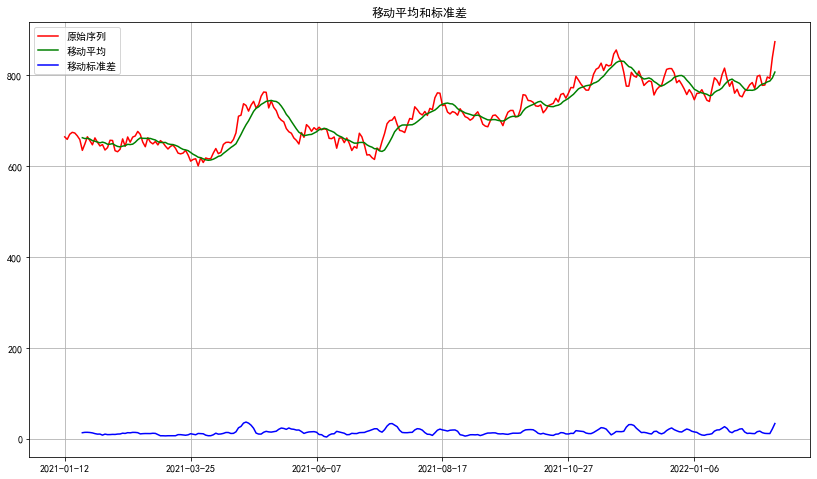

Dickey-Fuller test:
t-stat                   -0.980560
p-val                     0.760288
#lags used                0.000000
no. of obs              282.000000
Critical Value (1%)      -3.453754
Critical Value (5%)      -2.871844
Critical Value (10%)     -2.572261
dtype: float64


In [8]:
test_stationarity(ts)

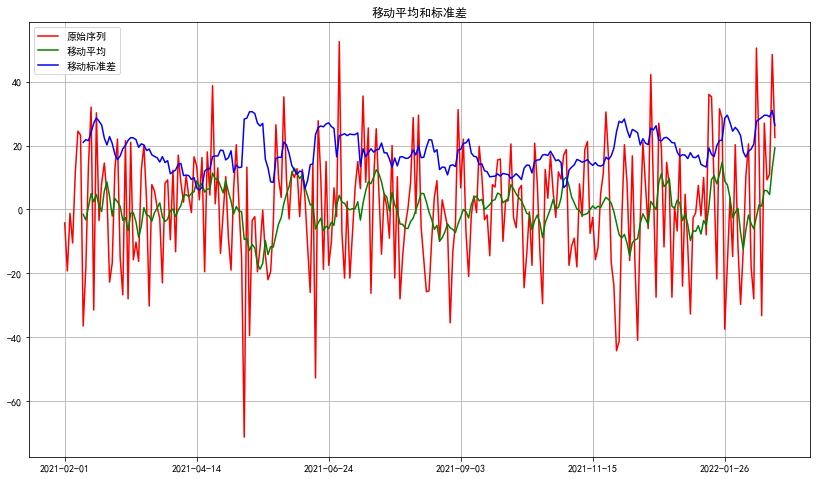

Dickey-Fuller test:
t-stat                 -7.076675e+00
p-val                   4.782113e-10
#lags used              1.100000e+01
no. of obs              2.580000e+02
Critical Value (1%)    -3.455953e+00
Critical Value (5%)    -2.872809e+00
Critical Value (10%)   -2.572775e+00
dtype: float64


In [9]:
ts_first_difference = ts - ts.shift(1) #一阶差分
ts_seasonal_first_difference = ts_first_difference - ts_first_difference.shift(12) #12步差分  
test_stationarity(ts_seasonal_first_difference.dropna(inplace=False))

In [10]:
import statsmodels.api as sm
ts_seasonal_first_difference.dropna(inplace = True)
r,q,p = sm.tsa.acf(ts_seasonal_first_difference.values.squeeze(), qstat=True) 
data = np.c_[range(1,41), r[1:], q, p] 
table = pd.DataFrame(data, columns=['lag', "AC", "Q", "Prob(>Q)"]) 
print(table.set_index('lag'))

            AC          Q      Prob(>Q)
lag                                    
1.0   0.029798   0.242416  6.224663e-01
2.0  -0.056370   1.113167  5.731638e-01
3.0   0.010537   1.143706  7.665351e-01
4.0  -0.052007   1.890461  7.558972e-01
5.0  -0.059837   2.882707  7.180630e-01
6.0   0.055073   3.726445  7.136384e-01
7.0   0.030734   3.990216  7.809037e-01
8.0   0.062652   5.090487  7.478624e-01
9.0  -0.030627   5.354419  8.023833e-01
10.0  0.074588   6.925878  7.324235e-01
11.0 -0.031865   7.213790  7.815155e-01
12.0 -0.457637  66.828874  1.249377e-09
13.0 -0.009016  66.852103  3.032157e-09
14.0  0.036408  67.232368  6.093659e-09
15.0 -0.012747  67.279166  1.357204e-08
16.0 -0.011565  67.317839  2.929117e-08
17.0  0.043365  67.863704  5.013907e-08
18.0 -0.090215  70.235580  4.122823e-08
19.0  0.010190  70.265963  8.307394e-08
20.0  0.015010  70.332150  1.607417e-07
21.0  0.048068  71.013626  2.414998e-07
22.0 -0.049162  71.729331  3.525143e-07
23.0  0.020936  71.859655  6.257408e-07


F:\anaconda\lib\site-packages\statsmodels\tsa\stattools.py:657: FutureWarning: The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.
  warnings.warn(
F:\anaconda\lib\site-packages\statsmodels\tsa\stattools.py:667: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


In [11]:
import warnings
warnings.filterwarnings("ignore") # specify to ignore warning messages
from statsmodels.tsa.arima_model import ARIMA 
 
pmax = int(5)    #一般阶数不超过 length /10
qmax = int(5)
aic_matrix = []
for p in range(pmax +1):
    temp= []
    for q in range(qmax+1):
        try:
            temp.append(ARIMA(ts, (p, 1, q)).fit().aic)
        except:
            temp.append(None)
        aic_matrix.append(temp)

aic_matrix = pd.DataFrame(aic_matrix)   #将其转换成Dataframe 数据结构
p,q = aic_matrix.stack().astype('float64').idxmin()   #先使用stack 展平， 然后使用 idxmin 找出最小值的位置
print(u'AIC 最小的p值 和 q 值：%s,%s' %(p,q))  #  BIC 最小的p值 和 q 值：0,1

AIC 最小的p值 和 q 值：0,0


In [12]:
import itertools
def get_ARIMA_params(data, pdq, m=12):
    p = d = q = range(0, 3)
    seasonal_pdq = [(x[0], x[1], x[2], m) for x in list(itertools.product(p, d, q))]
    score_aic = 1000000.0
    warnings.filterwarnings("ignore") # specify to ignore warning messages
    for param_seasonal in seasonal_pdq:
        mod = sm.tsa.statespace.SARIMAX(data,
                                        order=pdq,
                                        seasonal_order=param_seasonal,
                                        enforce_stationarity=False,
                                        enforce_invertibility=False)
        results = mod.fit()
        print('x{}12 - AIC:{}'.format(param_seasonal, results.aic))
        if results.aic < score_aic:
            score_aic = results.aic
            params = param_seasonal, results.aic
    param_seasonal, results.aic = params
    print('x{}12 - AIC:{}'.format(param_seasonal, results.aic))

In [13]:
pdq = [0, 1, 5]
get_ARIMA_params(ts, pdq)

x(0, 0, 0, 12)12 - AIC:2222.9567099647716
x(0, 0, 1, 12)12 - AIC:2130.0141120294447
x(0, 0, 2, 12)12 - AIC:2033.2528445496948
x(0, 1, 0, 12)12 - AIC:2311.119065388635
x(0, 1, 1, 12)12 - AIC:2059.320730716222
x(0, 1, 2, 12)12 - AIC:1970.6143807916426
x(0, 2, 0, 12)12 - AIC:2471.9915846890003
x(0, 2, 1, 12)12 - AIC:2123.6841566572284
x(0, 2, 2, 12)12 - AIC:1933.4724417932066
x(1, 0, 0, 12)12 - AIC:2174.9353540938
x(1, 0, 1, 12)12 - AIC:2127.9601233581807
x(1, 0, 2, 12)12 - AIC:2034.824802135412
x(1, 1, 0, 12)12 - AIC:2182.1243014351576
x(1, 1, 1, 12)12 - AIC:2061.3106534456465
x(1, 1, 2, 12)12 - AIC:1970.0860237842564
x(1, 2, 0, 12)12 - AIC:2279.667159793552
x(1, 2, 1, 12)12 - AIC:2074.394357066796
x(1, 2, 2, 12)12 - AIC:1935.436669716693
x(2, 0, 0, 12)12 - AIC:2081.101821707157
x(2, 0, 1, 12)12 - AIC:2082.981280035991
x(2, 0, 2, 12)12 - AIC:2036.570029087933
x(2, 1, 0, 12)12 - AIC:2055.870387905181
x(2, 1, 1, 12)12 - AIC:2019.4147566737045
x(2, 1, 2, 12)12 - AIC:1971.97289613244
x(2, 2,

In [14]:
mod = sm.tsa.statespace.SARIMAX(ts, trend='n', order=(0,1,0), seasonal_order=(0,2,2,12))
results = mod.fit()
print(results.summary())

                                        SARIMAX Results                                        
Dep. Variable:                                      收盘   No. Observations:                  283
Model:             SARIMAX(0, 1, 0)x(0, 2, [1, 2], 12)   Log Likelihood               -1098.728
Date:                                 Sat, 12 Mar 2022   AIC                           2203.456
Time:                                         21:23:35   BIC                           2214.115
Sample:                                              0   HQIC                          2207.742
                                                 - 283                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.S.L12      -1.7366      0.068    -25.621      0.000      -1.869      -1

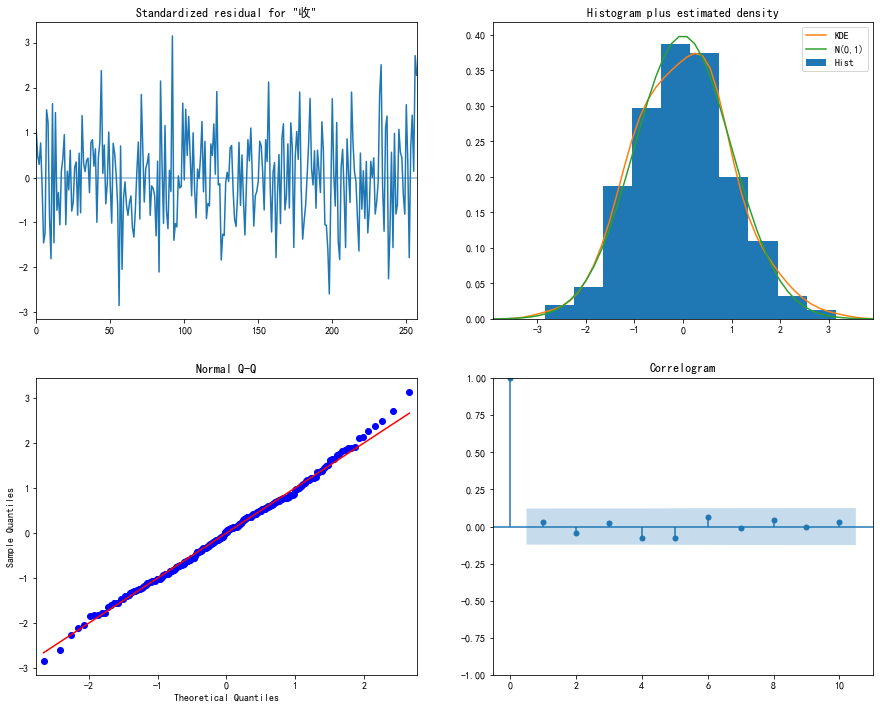

In [15]:
# 模型诊断
results.plot_diagnostics(figsize=(15, 12))
plt.show()

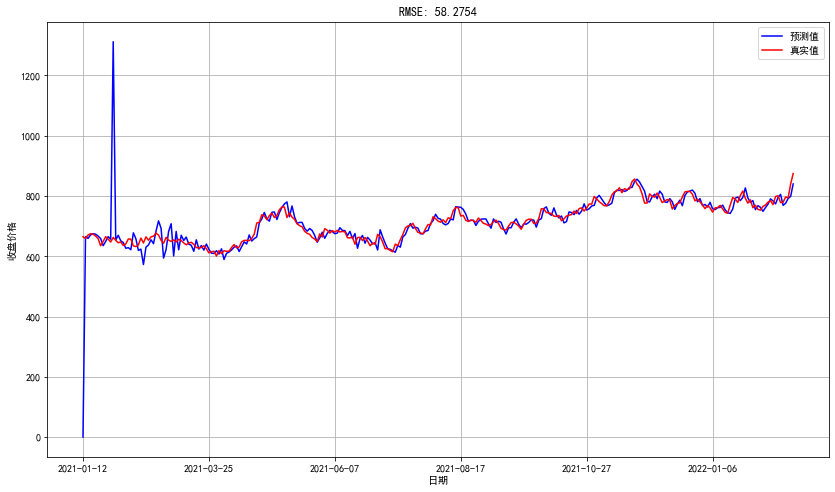

In [16]:
#静态预测
predict_ts = results.predict()
predict_ts.plot(color='blue', label='预测值')
ts.plot(color='red', label='真实值')
plt.legend(loc='best')
plt.title('RMSE: %.4f'% np.sqrt(sum((predict_ts-ts)**2)/ts.size))
#RMSE = np.sqrt(sum((predict_ts-ts)**2)/ts.size
plt.xlabel('日期')
plt.ylabel('收盘价格')
plt.grid()
plt.show()

In [17]:
pre = results.forecast(12)
print(pre)

283    872.277686
284    876.896415
285    887.027840
286    883.036005
287    891.898687
288    890.129257
289    888.030931
290    880.253126
291    882.100632
292    877.074232
293    893.265703
294    903.025656
Name: predicted_mean, dtype: float64


<Figure size 2160x720 with 0 Axes>

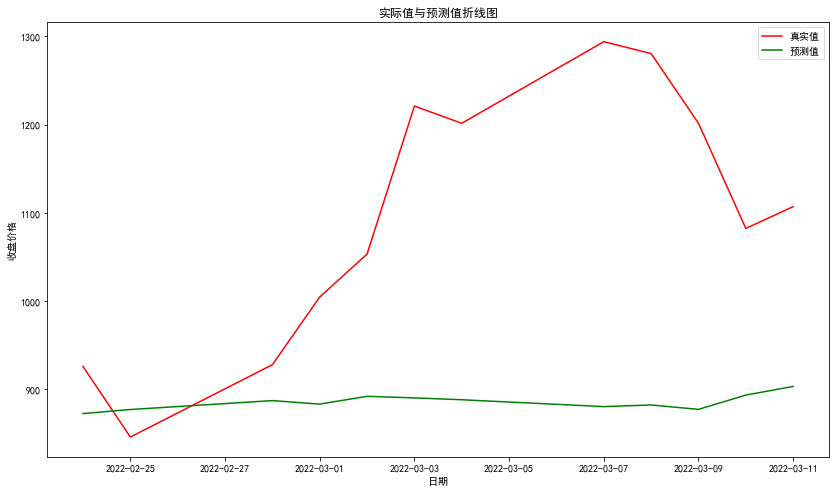

In [18]:
data3 = pd.read_excel('E:/postgraduate/案例选题数据及说明/小麦.xlsx')
#data3['时间'] = data3['时间'].str.split(',').str[0]

data3 = data3[['日期','真实值','预测值']]
plt.figure(figsize=(30,10))

x = data3['日期']
y1 = data3['真实值']
y2 = data3['预测值']
fig, ax = plt.subplots(1,1)
ax.plot(x,y1,color = 'r',label = '真实值')

#ax.xaxis.set_major_locator(ticker.MultipleLocator(base=20))

plt.plot(x,y2,color = 'g',label = '预测值')
plt.xlabel('日期')
plt.ylabel('收盘价格')
plt.title('实际值与预测值折线图')

plt.legend()
plt.show()